In [31]:
import pandas as pd
import numpy as np

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

/tmp/ipykernel_4396/146923546.py:6: DeprecationWarning:

Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.



In [40]:
df_train = pd.read_csv("data/train_data.csv", sep = ";")

In [42]:
df_train.head(10)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
0,27.22,105.59,26.91,108.67,0.51,0.20,True,2017-04-24,0.25
1,25.00,109.79,25.34,108.59,0.48,0.20,True,2017-07-27,0.25
2,27.10,105.60,29.35,106.54,0.48,0.20,True,2017-02-03,0.28
3,24.72,106.25,23.43,109.78,0.50,0.20,True,2017-04-03,0.28
4,22.33,108.37,29.38,111.50,0.48,0.20,True,2018-11-08,0.55
5,24.77,108.20,25.18,111.02,0.33,0.20,True,2019-01-14,0.35
6,25.76,109.61,27.30,105.00,0.47,0.09,True,2018-08-21,0.44
7,23.98,105.76,24.80,108.04,0.48,0.20,True,2017-03-28,0.31
8,27.93,107.13,27.78,109.51,0.50,0.20,True,2018-10-02,0.27
9,24.71,107.21,27.34,105.61,0.49,0.20,True,2017-03-14,0.26


In [43]:
df_train.tail()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
251150,25.14,111.73,26.10,106.74,0.32,0.20,True,2018-08-15,0.51
251151,24.00,110.82,24.98,104.39,0.50,0.20,True,2018-12-11,0.55
251152,26.95,105.52,24.66,110.34,0.49,0.21,True,2017-09-19,0.44
251153,26.91,108.67,27.30,105.00,0.49,0.06,True,2017-06-27,0.31
251154,22.45,107.36,24.63,107.41,0.25,0.20,True,2017-04-12,0.35


In [44]:
df_train.shape

(251155, 9)

In [45]:
df_train.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr',
       'shipping_date', 'cost'],
      dtype='object')

In [46]:
df_train.isnull().sum()

origin_latitude          0
origin_longitude         0
destination_latitude     0
destination_longitude    0
weight                   0
loading_meters           0
is_adr                   0
shipping_date            0
cost                     0
dtype: int64

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251155 entries, 0 to 251154
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   origin_latitude        251155 non-null  float64
 1   origin_longitude       251155 non-null  float64
 2   destination_latitude   251155 non-null  float64
 3   destination_longitude  251155 non-null  float64
 4   weight                 251155 non-null  float64
 5   loading_meters         251155 non-null  float64
 6   is_adr                 251155 non-null  bool   
 7   shipping_date          251155 non-null  object 
 8   cost                   251155 non-null  float64
dtypes: bool(1), float64(7), object(1)
memory usage: 15.6+ MB


In [48]:
df_train.nunique()

origin_latitude          776
origin_longitude         912
destination_latitude     803
destination_longitude    978
weight                   582
loading_meters           310
is_adr                     1
shipping_date            731
cost                     979
dtype: int64

In [49]:
df_train.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,cost
count,"251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00"
mean,25.70,108.93,25.58,108.97,0.41,0.17,0.34
std,1.78,2.09,1.98,2.30,0.13,0.06,0.13
min,21.71,102.97,21.65,103.00,0.05,0.00,0.02
25%,24.31,107.34,23.78,107.18,0.33,0.20,0.25
50%,25.65,108.89,25.64,109.40,0.47,0.20,0.33
75%,26.91,110.46,27.17,110.75,0.49,0.20,0.41
max,30.22,114.21,30.40,114.25,1.00,0.99,2.35


In [50]:
bool_features=df_train[['is_adr']]
bool_features.describe()

,is_adr
count,251155
unique,1
top,True
freq,251155


#### Changing the variable is_adr from Boolean values to integer

Changing the boolean value to numeric will help for further visualization and analysis

In [51]:
df_train["is_adr"] = df_train["is_adr"].astype(int)

In [52]:
df_train.head(4)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
0,27.22,105.59,26.91,108.67,0.51,0.20,1,2017-04-24,0.25
1,25.00,109.79,25.34,108.59,0.48,0.20,1,2017-07-27,0.25
2,27.10,105.60,29.35,106.54,0.48,0.20,1,2017-02-03,0.28
3,24.72,106.25,23.43,109.78,0.50,0.20,1,2017-04-03,0.28


Changing Time to datetime stamp

In [53]:
df_train['shipping_date'] = pd.to_datetime(df_train['shipping_date'], format='%Y-%m-%d')

In [54]:
df_train.head(10)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost
0,27.22,105.59,26.91,108.67,0.51,0.20,1,2017-04-24,0.25
1,25.00,109.79,25.34,108.59,0.48,0.20,1,2017-07-27,0.25
2,27.10,105.60,29.35,106.54,0.48,0.20,1,2017-02-03,0.28
3,24.72,106.25,23.43,109.78,0.50,0.20,1,2017-04-03,0.28
4,22.33,108.37,29.38,111.50,0.48,0.20,1,2018-11-08,0.55
5,24.77,108.20,25.18,111.02,0.33,0.20,1,2019-01-14,0.35
6,25.76,109.61,27.30,105.00,0.47,0.09,1,2018-08-21,0.44
7,23.98,105.76,24.80,108.04,0.48,0.20,1,2017-03-28,0.31
8,27.93,107.13,27.78,109.51,0.50,0.20,1,2018-10-02,0.27
9,24.71,107.21,27.34,105.61,0.49,0.20,1,2017-03-14,0.26


Text(0.5, 1.0, 'Correlation heat map')

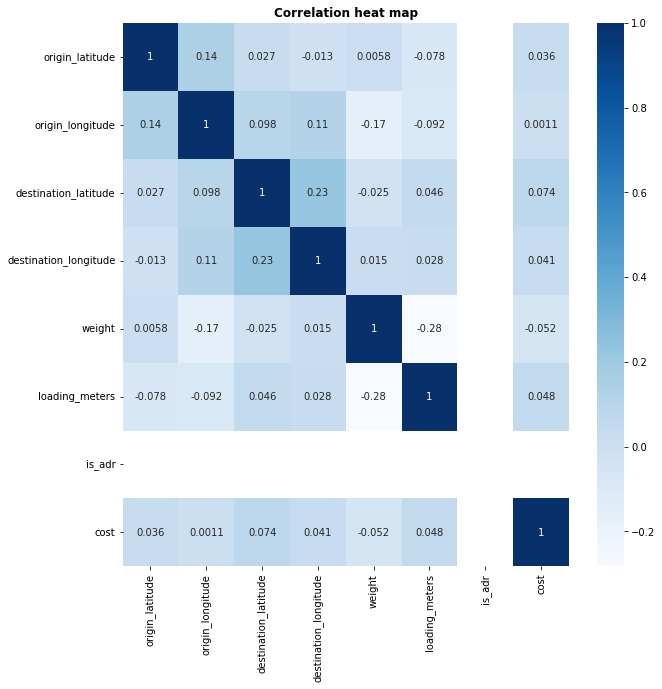

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(),cbar=True,annot=True,cmap='Blues')
plt.title('Correlation heat map', fontweight='bold')

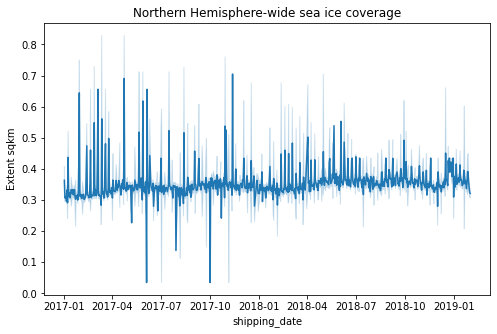

In [55]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['shipping_date'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='Northern Hemisphere-wide sea ice coverage', ylabel=r'Extent sqkm');

/root/.pyenv/versions/3.9.4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



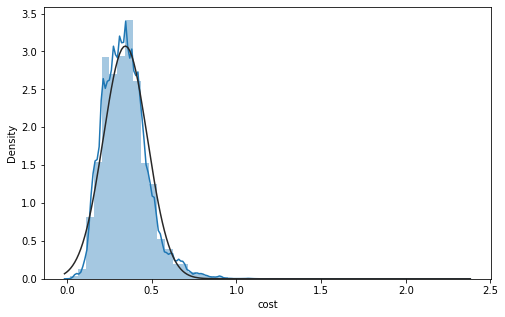

In [30]:
sns.distplot(df_train['cost'] , fit=norm);

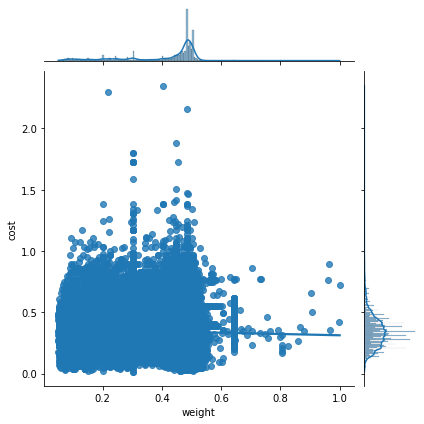

In [26]:
# Weight vs Cost
sns.jointplot(x=df_train['weight'], y=df_train['cost'], kind='reg')

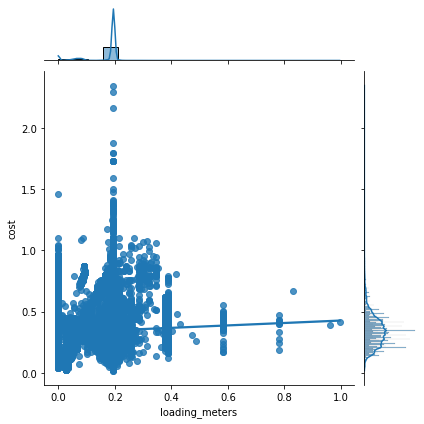

In [33]:
# Weight vs Cost
sns.jointplot(x=df_train['loading_meters'], y=df_train['cost'], kind='reg')